In [1]:
using DataFrames
using PyPlot

INFO: Loading help data...


#Function Declarations

In [2]:
function θ(X;t::Float64=0.5)
    return map(X) do x
        if x<t
            return 0
        else
            return 1
        end
    end
end
function θ!(X::Matrix{Float64};t::Float64=0.5)
    map!(X) do x
        if x<t
            return 0
        else
            return 1
        end
    end
end;

###Functions to Generate Separable Tiles 
Generates separable tiles, represented in a dataframe. Each row denotes a tile by center position (CX,CY) and the distances from the center to the edges (A1,A2,B1,B2), i.e. the corners of a tile are positioned at (CX-A2,CY+B1), (CX+A1,CY+B1),(CX+A1,CY-B2), (CX-A2,CY-B2) 

In [3]:
function generateTiles(n::Int64,
                    m::Int64,
                    r::Int64,
                    aMin::Int64,
                    aMax::Int64,
                    bMin::Int64,
                    bMax::Int64;
                    maxTrials::Int64=100)
    tiles= DataFrame(CX = Int64[],CY = Int64[],A1 = Int64[],A2 = Int64[],B1 = Int64[],B2 = Int64[])
    k=0
    trials = 0;
    x=aMin+1:n-aMin #possible center x values
    y=bMin+1:m-bMin #possible center y values
    while k< r && trials < maxTrials
        #print(k," ")
        if isempty(x[x.>0]) || isempty(y[y.>0]) #restart
            tiles= DataFrame(CX = Int64[],CY = Int64[],A1 = Int64[],A2 = Int64[],B1 = Int64[],B2 = Int64[])
            k=0
            x=aMin+1:n-aMin #possible center x values
            y=bMin+1:m-bMin #possible center y values
            trials+=1
            continue
        end
        cx = x[x.>0][rand(1:size(x[x.>0],1))]
        cy = y[y.>0][rand(1:size(y[y.>0],1))]
        a1Max = min(cx-1,aMax,n-cx) 
        if sum(cx.>tiles[:CX])>0 #if cx lies to the right of another tile
            #let the current tile not cover the center of the next tile on the left
            a1Max = min(a1Max,cx-maximum(tiles[cx.>tiles[:CX],:CX])) 
        end
        if sum(cx.<tiles[:CX])>0
            #let the current tile not cover the center of the next tile on the right
            a1Max = min(a1Max,minimum(tiles[cx.<tiles[:CX],:CX])-cx)
        end
        b1Max = min(cy-1,bMax,m-cy) 
        if sum(cy.>tiles[:CY]) >0
            #let the current tile not cover the center of the tile below
            b1Max = min(b1Max,cy-maximum(tiles[cy.>tiles[:CY],:CY]))
        end
        if sum(cy.<tiles[:CY])>0
            #let the current tile not cover the center of the tile above
            b1Max = min(b1Max,minimum(tiles[cy.<tiles[:CY],:CY])-cy)
        end
        a1 = rand(aMin:a1Max) # horizontal distances from cx to right and  left edges
        b1 = rand(bMin:b1Max) # vertical distances from cy to upper and lower edges
        aDelta = max(a1-aMin/2,aMin) # minimum horizontal distance to next tile center
        bDelta = max(b1-bMin/2,bMin) # minimum vertical distance to next tile center
        x=x.*((x.<cx-aDelta) | (x.>cx+aDelta))
        y=y.*((y.<cy-bDelta) | (y.>cy+bDelta))
        push!(tiles,[cx cy a1 a1 b1 b1])
        k+=1
    end
    println("trials: ",trials);
    return (trials,tiles)
end;

Function to create data matrix according to positions denoted in the DataFrame

In [4]:
function getFactorization(tiles::DataFrame, # tiles as generated by function above
    n::Int64, # number of items
    m::Int64, # number of transactions
    r::Int64) # number of generated tiles
    X = zeros(Int64,r,n)
    Y = zeros(Int64,m,r)
    for s=1:r
        for i in tiles[s,:CX]-tiles[s,:A1]:tiles[s,:CX]+tiles[s,:A2]
            X[s,i] = 1;
        end
        for j in tiles[s,:CY]-tiles[s,:B1]:tiles[s,:CY]+tiles[s,:B2]
            Y[j,s] = 1;
        end
    end
    return (X,Y)
end;

###Function to Generate Partially Separable Tiles 
Generate a factor matrix of r partially separable tiles

In [5]:
function generateFactor(
    n::Int64, #dimension
    r::Int64, #rank
    lMin::Int64, #minimum length of a tile (block size)
    dMax::Int64 #maximum density of random part 
    )
    X=int(zeros(n,r))
    t = r*lMin+1 #current transaction index
    for s = 1:r
        a = (s-1)*lMin+1
        b = s*lMin
        X[a:b,s]=1 #create block
        d = rand(0:dMax)+t
        X[t:d,s]=1
        X[t:n,s]=shuffle(X[t:n,s])
    end
    return X
end;

###Functions to Plot and to Add Noise 
Function to plot matrices

In [16]:
function plot(D::Array{Int64,2})
    set_cmap("Set3")
    figure(figsize = [2,4])
    ax = axes(aspect=1)
    axis("off")
    imshow(D,interpolation="none")
end;

Function to add noise

In [7]:
function addNoise(D::Array{Int64,2}, # data matrix with original tiles
    pminus::Float64, # probability to flip a one to zero
    pplus::Float64) #probability to flip a zero to one
    DNoise = copy(D)
    for i = 1:size(D,2)
        for j = 1:size(D,1)
            if D[j,i] ==0
                if rand() <= pplus
                    DNoise[j,i]=1
                end
            else
                if rand() <= pminus
                    DNoise[j,i]=0
                end
            end
        end
    end
    return DNoise
end;

#Generate Matrices

In [8]:
m=1500
n=600
r=30;

Separable Tiles

In [18]:
aMin = convert(Int64,n/100*1)
aMax = convert(Int64,n/100*10)
bMin = convert(Int64,m/100*1)
bMax = convert(Int64,m/100*10);

trials: 11


Figure(PyObject <matplotlib.figure.Figure object at 0x7f9a462a9210>)

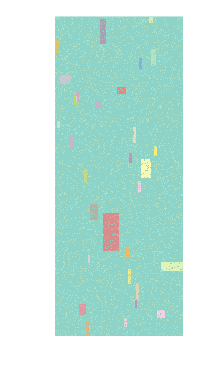

In [22]:
(trials,tiles)=generateTiles(n,m,r,aMin,aMax,bMin,bMax,maxTrials = 1000);
if trials == 1000
    println("Fail to generate dataset with ",r," tiles")
    continue
end
(X,Y) = getFactorization(tiles,n,m,r);
D=Y*((1:r).*X)
p₊=10 #%
p₋=10 #%
DN = addNoise(D,p₋/100,p₊/100);
plot(DN)
savefig(string("RandomTilesPlot/TNpos",p₊,"neg",p₋,"r",r,".pdf"))
close()
writedlm(string("RandomTiles/TNpos",p₊,"neg",p₋,"r",r,".csv"),θ(DN),'\t')

Partially separable tiles

In [25]:
#at least 1% of uniquely assigned ones for each tile 
lxMin = int(ceil(n/100)) 
lyMin = int(ceil(m/100))
d = 10 #% maximum density in random part
dxMax = int(ceil((n-r*lxMin)*d/100))
dyMax = int(ceil((m-r*lyMin)*d/100));

Figure(PyObject <matplotlib.figure.Figure object at 0x7f9a4629e210>)

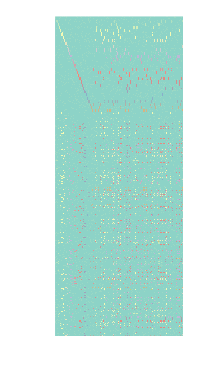

In [26]:
X = generateFactor(n,r,lxMin,dxMax).'
Y = generateFactor(m,r,lyMin,dyMax)
D=Y*((1:r).*X)
p₊=10 #%
p₋=10 #%
DN = addNoise(D,p₋/100,p₊/100);
plot(DN)
close()